<a href="https://colab.research.google.com/github/solharsh/All_Neural_Networks/blob/master/Gluon_MXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MXNet/Gluon

- Reference: https://beta.mxnet.io/guide/2-nn.html
- Youtube Crash Course on MXNet: https://www.youtube.com/watch?v=3FR4jO0rk0o

Neural Networks with Gluon
Building, training and validating a Neural Network in Gluon.

In [17]:
!pip install mxnet-cu100 #this is how I was able to install mxnet in google colab
#For other systems, please refer following: 
#https://beta.mxnet.io/install/index.html

     |████████████████████████████████| 540.1MB 27kB/s 


In [0]:
import mxnet as mx
from mxnet import nd

In [38]:
from mxnet.gluon import nn
 
net = nn.Sequential()
 
net.add(nn.Dense(64,                    # Dense layer-1 (fully connected layer) with 64 units
                 in_units=3,            # Input size of 3 is expected
                 activation='tanh'),    # Tanh activation is applied
        nn.Dropout(.4),                 # Apply random 40% drop-out to layer_1
        
        nn.Dense(128,                   # Dense layer-2 with 128 units  
                 activation='tanh'      # Tanh activation is applied
                ),
        nn.Dropout(.3),                 # Apply random 30% drop-out to layer_2
        
        nn.Dense(1))                    # Output layer with single unit
 
print(net)

Sequential(
  (0): Dense(3 -> 64, Activation(tanh))
  (1): Dropout(p = 0.4, axes=())
  (2): Dense(None -> 128, Activation(tanh))
  (3): Dropout(p = 0.3, axes=())
  (4): Dense(None -> 1, linear)
)


### 2. Loss Functions:

We will go over some popular loss functions here. We can select loss functions according to our problem. 

__Binary Cross-entropy Loss:__ A common loss function for binary classification. It is given by: 
$$
\mathrm{BinaryCrossEntropyLoss} = -\sum_{examples}{(y\log(p) + (1 - y)\log(1 - p))}
$$
where p is the prediction (between 0 and 1, ie. 0.831) and y is the true class (either 1 or 0). 

In gluon, we can use binary cross entropy with `SigmoidBinaryCrossEntropyLoss`. It also applies sigmoid function on the predictions. Therefore, p is always between 0 and 1.
```python
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
loss = SigmoidBinaryCrossEntropyLoss()
```
__Categorical Cross-entropy Loss:__ It is used for multi-class classification. We apply the softmax function on prediction probabilities and then extend the equation of binary cross-entropy. After the softmax function, summation of the predictions are equal to 1. Equation is below. y becomes 1 for true class and 0 for other classes.
$$
\mathrm{CategoricalCrossEntropyLoss} = -\sum_{examples}\sum_{classes}{y_j\log(p_j)}
$$
In gluon, `SoftmaxCrossEntropyLoss` implements the categorical cross-entropy loss with softmax function
```python
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
loss = SoftmaxCrossEntropyLoss()
```
__L2 Loss:__ This is a loss function for regression problems. It measures the squared difference between target values (y) and predictions (p). Here, square makes sure the offsets with different signs don't cancel out each other.
$$
\mathrm{L2 loss} = \frac{1}{2} \sum_{examples}(y - p)^2
$$
In gluon, we can use it with `L2Loss`:
```python
from mxnet.gluon.loss import L2Loss
loss = L2Loss()
```
__L1 Loss:__ This is similar to L2 loss. It measures the abolsute difference between target values (y) and predictions (p).
$$
\mathrm{L1 loss} = \frac{1}{2} \sum_{examples}|y - p|
$$
In gluon, we can use it with `L1Loss`:
```python
from mxnet.gluon.loss import L1Loss
loss = L1Loss()
```

In [0]:
#We can initialize the weights of the network with 'initialize()' function. I am using following:
from mxnet import init
net.initialize(init=init.Xavier())

In [0]:
#we can also do following: 
#net.initialize() #initialize weights with the default initialization method, which draws random values uniformly from  
#[−0.7,0.7]

In [40]:
#Let's look at our layers and dropouts on them. We can easily access them wth net[layer_index]
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Dense(3 -> 64, Activation(tanh))
Dropout(p = 0.4, axes=())
Dense(None -> 128, Activation(tanh))
Dropout(p = 0.3, axes=())
Dense(None -> 1, linear)


### 3. Training:

`mxnet.gluon.Trainer()` module provides necessary training algorithms for neural networks. We can use the following for training a network using Stochastic Gradient Descent method and learning rate of 0.001.

```python
from mxnet import gluon

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', 
                        {'learning_rate': 0.001}
                       )
```

### 4. Example - Binary Classification

Let's train a neural network on a random dataset. We have two classes and will learn to classify them.

In [0]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=100, noise=0.05, factor=0.3)

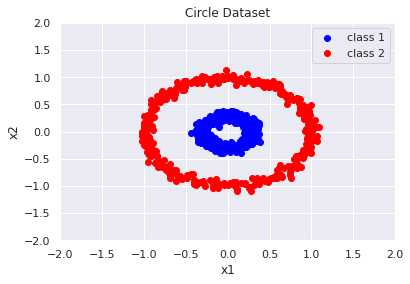

In [48]:
#Let's plot the dataset
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Circle Dataset")

In [0]:
#Importing the necessary libraries
import time
import mxnet as mx
from mxnet import gluon, autograd
import mxnet.ndarray as nd
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

Creating the network below. We will have two hidden layers. Since the data seems easily seperable, we can have a small network (2 hidden layers) with 10 units at each layer.

In [0]:
from mxnet import init
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Dense(10, in_units=2, activation='relu'),
        nn.Dense(10, activation='relu'),
        nn.Dense(1, activation='sigmoid'))
net.initialize(init=init.Xavier())

In [0]:
#Let's define the training parameters
batch_size = 4           # How many samples to use for each weight update 
epochs = 50              # Total number of passes over the dataset
learning_rate = 0.01     # Learning rate
context = mx.cpu()       # Using CPU resource, mx.gpu() uses available gpu resources if any

# Define the loss. As we used sigmoid in the last layer, use from_sigmoid=True
binary_cross_loss = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)

# Define the trainer, SGD with learning rate
trainer = gluon.Trainer(net.collect_params(),
                        'sgd',
                        {'learning_rate': learning_rate}
                       )

In [0]:
# Splitting the dataset into two parts: 80%-20% split
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# Convert to ND arrays for gluon
X_train = nd.array(X_train)
X_val = nd.array(X_val)
y_train = nd.array(y_train)
y_val = nd.array(y_val)

# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(X_train, y_train)
train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)

In [53]:
#Let's start the training process. We will have training and validation sets and print our losses at each step.
import time

train_losses = []
val_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Training loop, train the network
    for idx, (data, target) in enumerate(train_loader):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = net(data)
            L = binary_cross_loss(output, target)
            training_loss += nd.sum(L).asscalar()
            L.backward()
        trainer.step(data.shape[0])
    
    # Get validation predictions
    val_predictions = net(X_val.as_in_context(context))
    # Calculate validation loss
    val_loss = nd.sum(binary_cross_loss(val_predictions, y_val)).asscalar()
    
    # Let's take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
          (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.691127 Validation_loss 0.684156 Seconds 0.373871
Epoch 1. Train_loss 0.682775 Validation_loss 0.674499 Seconds 0.373239
Epoch 2. Train_loss 0.671357 Validation_loss 0.658384 Seconds 0.376725
Epoch 3. Train_loss 0.646834 Validation_loss 0.633070 Seconds 0.381902
Epoch 4. Train_loss 0.627151 Validation_loss 0.615103 Seconds 0.385168
Epoch 5. Train_loss 0.608756 Validation_loss 0.594578 Seconds 0.386652
Epoch 6. Train_loss 0.587047 Validation_loss 0.570267 Seconds 0.373059
Epoch 7. Train_loss 0.561343 Validation_loss 0.541555 Seconds 0.375184
Epoch 8. Train_loss 0.531153 Validation_loss 0.508014 Seconds 0.381975
Epoch 9. Train_loss 0.496159 Validation_loss 0.469403 Seconds 0.378404
Epoch 10. Train_loss 0.456319 Validation_loss 0.425984 Seconds 0.379744
Epoch 11. Train_loss 0.412004 Validation_loss 0.378481 Seconds 0.376893
Epoch 12. Train_loss 0.364185 Validation_loss 0.328750 Seconds 0.375534
Epoch 13. Train_loss 0.315144 Validation_loss 0.280589 Seconds 0.374685
Ep

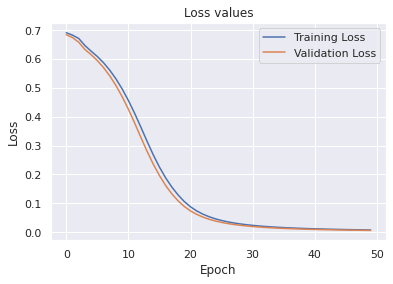

In [54]:
#Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()